In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline

**Загрузка датасета Labeled Faces in the Wild Home**

В датасете:
 - 13233 изображений;
 - 5749 людей;
 - 1680 людей с двумя или более изображениями.

10% отложим на тест.

In [0]:
tfds.disable_progress_bar()
(train_ds, test_ds) = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=False,
    split=['train[:90%]', 'train[90%:]']
)

В датасете сначала идёт лейбл, затем - изображение:

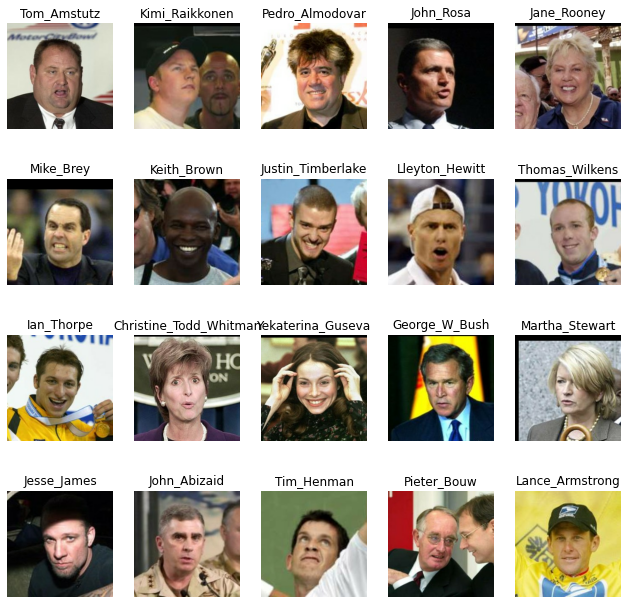

In [4]:
some_samples = [x for x in iter(train_ds.take(20))]

fig = plt.figure(figsize=(11, 11))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 5, j+1)
    ax.imshow(some_samples[j][1])
    label = some_samples[j][0].numpy()
    title = label.decode('utf-8')
    ax.set_title(title)
    plt.axis('off')

### Сиамская нейронная сеть

Архитектура сети осталась из видеоурока, изменения - в уменьшении *kernel_size* и увеличении EMD_SIZE. [Здесь](https://www.kaggle.com/jake126/face-detection-using-cnn-with-the-lfw-dataset) в задаче классификации на данном датасете использовалась схожая архитектура.

In [0]:
EMD_SIZE = 128

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),                             
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMD_SIZE, activation=None),    
])

Отступ MARGIN также увеличен:

In [0]:
MARGIN = 100.

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1-embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)

    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2), z


В качестве обработки меняем местами лейбл и изображение для привычного порядка и нормируем изображение. В данной задаче лейблы можно оставить в исходном виде.

Тестовую выборку делим на батчи по 500 объектов.

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 10

def prepare(label, img):
    img = tf.cast(img, tf.float32) / 255.
    return img, label

train_ds = train_ds.map(prepare)
train_ds = train_ds.shuffle(buffer_size=10000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(500)

## Обучение модели

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [9]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value, z = contrastive_loss(embs, labels)

    # backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 100 == 0:
        print('[{:4d}] Loss: {:.3f}'.format(iteration, loss_value))
        

[   0] Loss: 9913.074
[ 100] Loss: 6.250
[ 200] Loss: 22.696
[ 300] Loss: 6.618
[ 400] Loss: 0.000
[ 500] Loss: 24.820
[ 600] Loss: 2.364
[ 700] Loss: 12.013
[ 800] Loss: 5.616
[ 900] Loss: 41.450
[1000] Loss: 0.000
[1100] Loss: 0.000
[1200] Loss: 5.477
[1300] Loss: 0.000
[1400] Loss: 9.360
[1500] Loss: 4.186
[1600] Loss: 1.958
[1700] Loss: 0.000
[1800] Loss: 3.758
CPU times: user 3min 14s, sys: 54.5 s, total: 4min 9s
Wall time: 4min 14s


In [0]:
model.save('/content/drive/My Drive/lfw_model.h5')

## Проверка работы модели

Загрузим тестовый батч из 500 изображений и получим для него эмбеддинги:

In [0]:
NUM_TEST_BATCHES = 1

for (images, labels) in iter(test_ds.take(NUM_TEST_BATCHES)):
    test_embs = model(images).numpy()
    test_images = images.numpy()
    test_labels = labels.numpy()

Сократим размерность полученных эмбеддингов со EMD_SIZE = 128 до 2 с помощью TSNE:

In [0]:
embs_tsne = TSNE(n_components=2, random_state=21).fit_transform(test_embs)

Визуализируем преобразованные эмбеддинги для людей. у которых оказалось более 2-х изображений в тестовом батче:

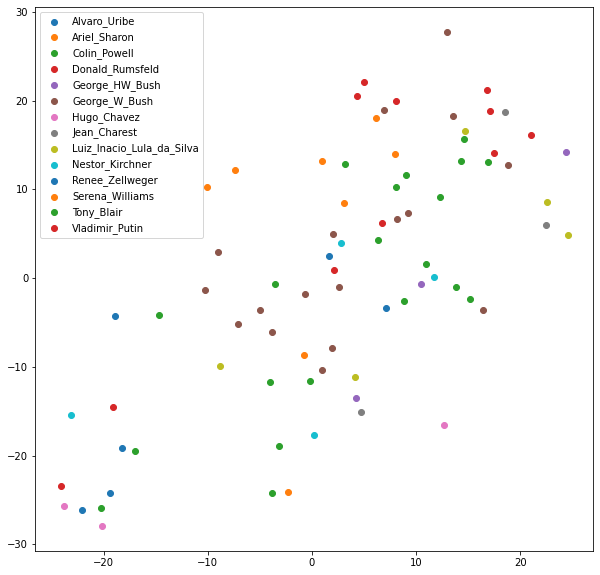

In [13]:
plt.figure(figsize=(10, 10))
for person, count in zip(*np.unique(test_labels, return_counts=True)):
    if count > 2:
        embs_by_person = embs_tsne[test_labels == person, :]
        plt.scatter(embs_by_person[:, 0], embs_by_person[:, 1], label=person.decode('utf-8'))
plt.legend(loc='best')
plt.show()

Представление получилось не особо информативным по следующим возможным факторам:
 - сеть обучалась на датасете с большим количеством классов и малым количеством примеров для каждого из них;
 - влияние TSNE-преобразования;
 - влияние архитектуры модели, гиперпараметров и, в частности, фукции потерь.

Возьмем по три изображения с соответствующими эмбеддингами для Владимира Путина, Тони Блэра и Уго Чавеса:

In [0]:
vp_e1, vp_e2, vp_e3 = test_embs[test_labels == b'Vladimir_Putin'][:3]
vp_i1, vp_i2, vp_i3 = test_images[test_labels == b'Vladimir_Putin'][:3]

tb_e1, tb_e2, tb_e3 = test_embs[test_labels == b'Tony_Blair'][:3]
tb_i1, tb_i2, tb_i3 = test_images[test_labels == b'Tony_Blair'][:3]

hc_e1, hc_e2, hc_e3 = test_embs[test_labels == b'Hugo_Chavez'][:3]
hc_i1, hc_i2, hc_i3 = test_images[test_labels == b'Hugo_Chavez'][:3]

С помощью данных функций покажем некоторые пары изображений и рассчитаем еклидовую норму разности соответствующих им эмбеддингов:

In [0]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


def calc_embs_diff(e1, e2, i1, i2):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(i1); axes[0].axis('off')
    axes[1].imshow(i2); axes[1].axis('off')
    plt.show()
    
    print(f'\n\teuclid norm: {diff(e1, e2):.3f}\n')    


Пары изображений одного и тогоже человека:

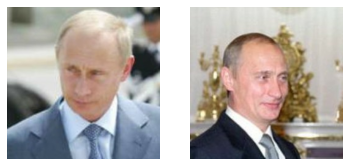


	euclid norm: 65.652



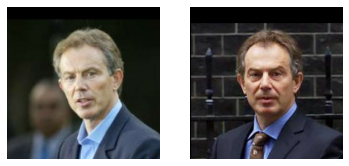


	euclid norm: 55.692



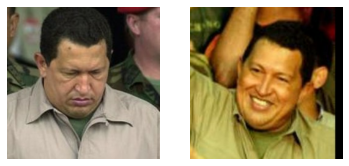


	euclid norm: 309.206



In [16]:
calc_embs_diff(vp_e1, vp_e2, vp_i1, vp_i2)
calc_embs_diff(tb_e2, tb_e3, tb_i2, tb_i3)
calc_embs_diff(hc_e3, hc_e2, hc_i3, hc_i2)

Пары изображений с разными людьми:

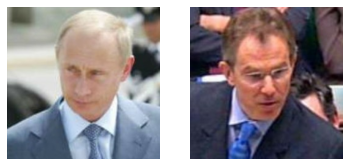


	euclid norm: 153.427



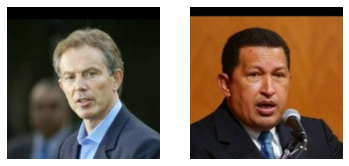


	euclid norm: 323.073



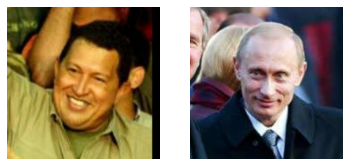


	euclid norm: 398.641



In [17]:
calc_embs_diff(vp_e1, tb_e1, vp_i1, tb_i1)
calc_embs_diff(tb_e2, hc_e1, tb_i2, hc_i1)
calc_embs_diff(hc_e2, vp_e3, hc_i2, vp_i3)

В целом, на этих данных этот вариант сети получился самым удачным - у изображений с одним человеком векторы эмбеддингов близки (за исключением Уго Чавеса), у изображений с разными людьми - далеки. Однако с другими изображениями или после обучения заново, а также при других гиперпараметрах картина будет иной.

Причина, в первую очередь, в датасете: слишком много классов, слишком мало данных для каждого из них. В качестве варианта можно отобрать людей, у которых достаточно фотографий, и обучать сиамскую сеть (возможно даже такой же архитектуры) относительно них.